<a href="https://colab.research.google.com/github/snehasingh0125/house-prediction/blob/main/house_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction 🏡

This notebook demonstrates a supervised regression task: predicting house prices based on various features. We'll go through the complete machine learning pipeline from data exploration to model evaluation.

**Objective:** Predict the median house value for California districts, given a number of features from the 1990 census data.

**Note:** The Boston Housing dataset, previously available in scikit-learn, is now deprecated due to ethical concerns. We will use the California Housing dataset instead, which is a more modern and suitable alternative for this task.

---

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

---

## 2. Load Dataset
We load the California Housing dataset from `sklearn.datasets` and convert it into a pandas DataFrame for easier manipulation.

In [ ]:
# Fetch the dataset
housing = fetch_california_housing()

# Create a DataFrame
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target # The target variable

print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


---

## 3. Explore and Clean Data (EDA)
Let's explore the data to understand its characteristics, find missing values, and check distributions.

In [ ]:
# Get a summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
# Check for null values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


The dataset is clean with no missing values. Now, let's look at the statistical summary.

In [ ]:
# Get statistical summary
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Let's visualize the distribution of each feature and the target variable.

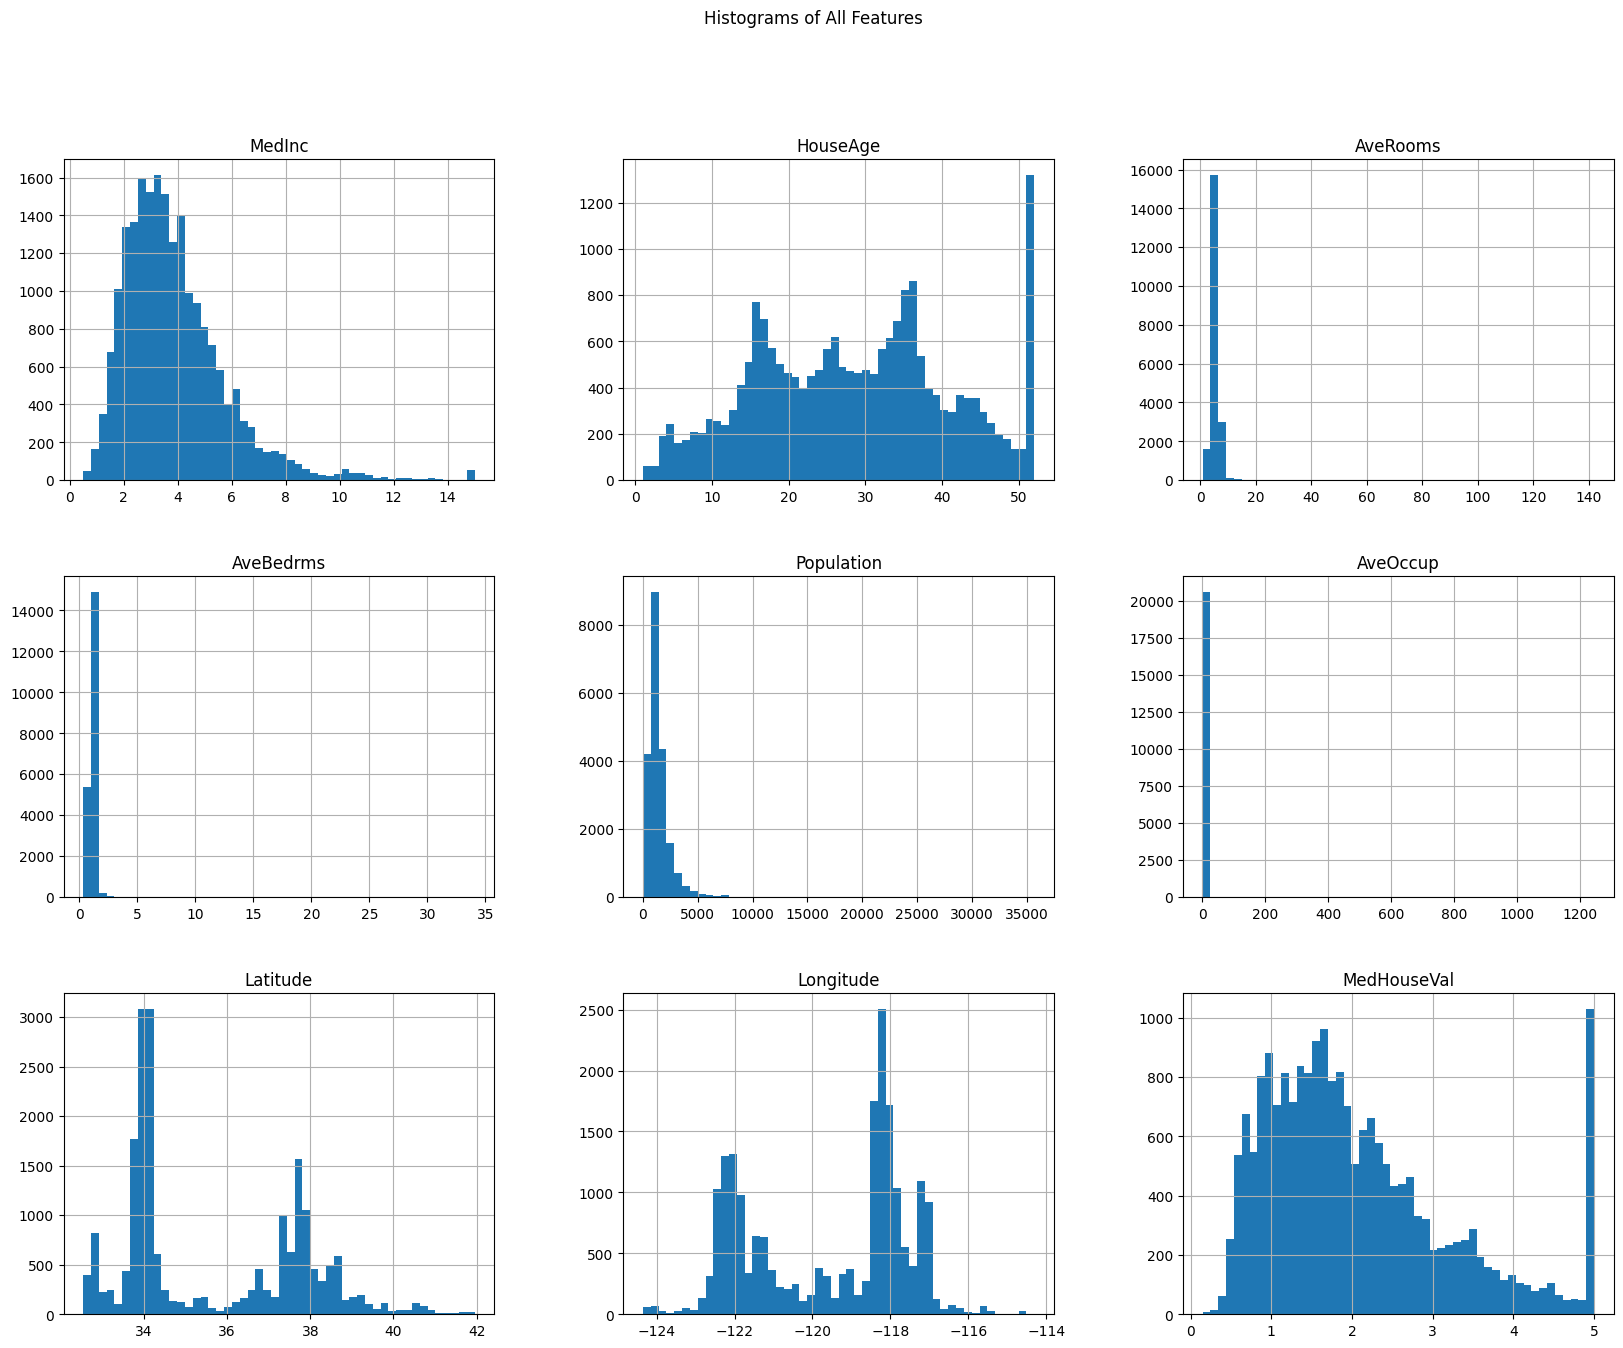

In [ ]:
# Plot histograms for all features
df.hist(bins=50, figsize=(20, 15))
plt.suptitle('Histograms of All Features')
plt.show()

**Observations:**
- Many histograms are **right-skewed** (e.g., `MedInc`, `HouseAge`, `AveRooms`).
- `AveRooms`, `AveBedrms`, `Population`, and `AveOccup` have some significant outliers on the higher end.
- The target variable `MedHouseVal` is also right-skewed and appears to be capped at around 5.0.

---

## 4. Feature Selection and Engineering
We'll check for correlations between features to understand relationships. Highly correlated features can sometimes be redundant.

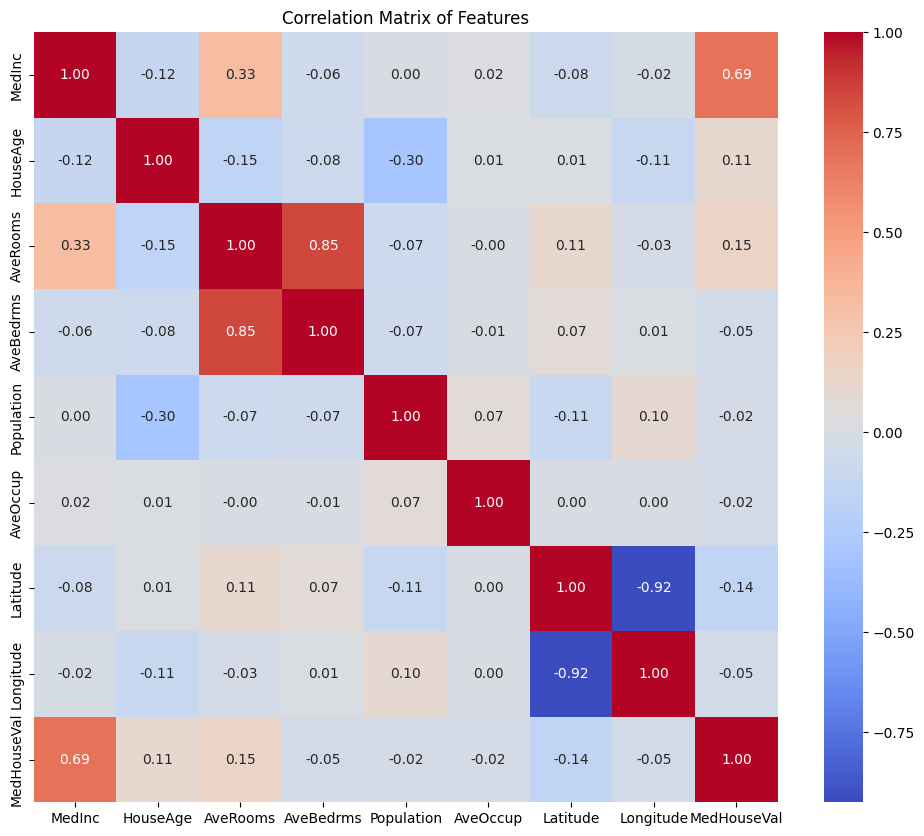

In [ ]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

**Observations:**
- `MedInc` (Median Income) has the strongest positive correlation with `MedHouseVal` (0.69).
- `AveRooms` also has a noticeable positive correlation.
- `Latitude` has a negative correlation.
- `AveRooms` and `AveBedrms` are highly correlated with each other. For this basic example, we will keep all features, but in a real-world project, one might be removed.

Now, let's define our features (X) and target (y).

In [ ]:
# Define features (X) and target (y)
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

---

## 5. Split Data and Scale Features
We split the data into training and testing sets. We will also scale the features, which is important for distance-based algorithms and helps gradient-based models converge faster.

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

## 6. Train Models
We will train three different regression models: Linear Regression, Random Forest, and XGBoost.

In [ ]:
# Initialize models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train models
lin_reg.fit(X_train_scaled, y_train)
rf_reg.fit(X_train_scaled, y_train)
xgb_reg.fit(X_train_scaled, y_train)

print("Models trained successfully!")

Models trained successfully!


---

## 7. Evaluate Models
Let's evaluate the models using three key regression metrics: **R-squared ($R^2$)**, **Mean Absolute Error (MAE)**, and **Root Mean Squared Error (RMSE)**. We'll use the Random Forest model for a detailed look.

In [ ]:
# Make predictions with the Random Forest model
y_pred_rf = rf_reg.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest Regressor Performance:")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Random Forest Regressor Performance:
R-squared (R²): 0.8053
Mean Absolute Error (MAE): 0.3274
Root Mean Squared Error (RMSE): 0.5051


An **$R^2$ of 0.81** means our model explains about 81% of the variance in the house prices, which is a good result. The **RMSE** of 0.50 means our model's predictions are, on average, off by about $50,000 (since the target is in units of $100,000).

Let's visualize the predictions against the actual values.

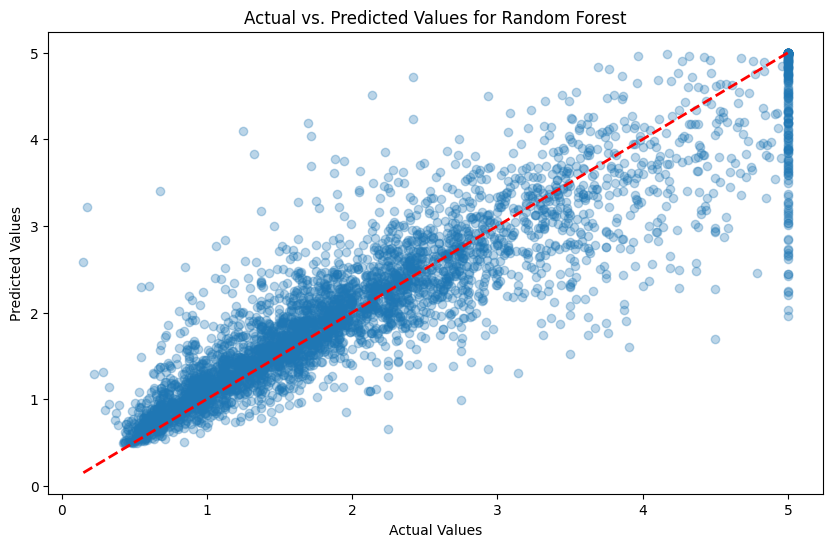

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Random Forest')
plt.show()

---

## 8. Bonus: Deploy using Streamlit
To create a simple web app for our model, we first need to save the trained model and the scaler.

In [ ]:
# Save the Random Forest model and the scaler
joblib.dump(rf_reg, 'house_price_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


### Streamlit App Code (`app.py`)

Create a new Python file named `app.py`, paste the following code into it, and save it in the same directory as your saved model and scaler files.

**To run the app:**
1. Ensure you have Streamlit installed (`pip install streamlit`).
2. Open your terminal, navigate to the correct directory, and run: `streamlit run app.py`

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the pre-trained model and scaler
model = joblib.load('house_price_rf_model.pkl')
scaler = joblib.load('scaler.pkl')

# Set up the Streamlit app title
st.set_page_config(page_title="California House Price Predictor", page_icon="🏡")
st.title('🏡 California House Price Predictor')
st.write('This app predicts the median house value for a district in California.')

# Create input fields in the sidebar
st.sidebar.header('Input Features')

def user_input_features():
    med_inc = st.sidebar.number_input('Median Income (in tens of thousands of $)', min_value=0.0, max_value=16.0, value=3.5, step=0.1)
    house_age = st.sidebar.slider('Housing Median Age', 1, 52, 25)
    ave_rooms = st.sidebar.slider('Average Number of Rooms', 1.0, 10.0, 5.0, 0.1)
    ave_bedrms = st.sidebar.slider('Average Number of Bedrooms', 0.5, 5.0, 1.0, 0.1)
    population = st.sidebar.number_input('District Population', min_value=1, max_value=40000, value=1500, step=100)
    ave_occup = st.sidebar.slider('Average House Occupancy', 1.0, 10.0, 2.5, 0.1)
    latitude = st.sidebar.slider('Latitude', 32.0, 42.0, 36.0, 0.1)
    longitude = st.sidebar.slider('Longitude', -124.0, -114.0, -119.0, 0.1)

    data = {'MedInc': med_inc,
            'HouseAge': house_age,
            'AveRooms': ave_rooms,
            'AveBedrms': ave_bedrms,
            'Population': population,
            'AveOccup': ave_occup,
            'Latitude': latitude,
            'Longitude': longitude}

    features = pd.DataFrame(data, index=[0])
    return features

input_df = user_input_features()

# Display user's input
st.subheader('Your Input Features')
st.write(input_df)

# Scale the input features
input_scaled = scaler.transform(input_df)

# Prediction button
if st.button('Predict House Price'):
    prediction = model.predict(input_scaled)
    predicted_price = prediction[0] * 100000  # Convert back to actual price

    st.subheader('Prediction')
    st.success(f'The predicted median house value is **${predicted_price:,.2f}**')

Writing app.py
